# Markov prediction
In this notebook we will implement (arguably) the most simple form of sequence generation: each subsequent token (character) is generated by sampling from the conditional probability distribution $P(X_t \mid X_{t-1}) \sim Multinomial_{X_{t-1}}(N_{tokens})$, i.e. every character (token) has an associated probility table for what the next character (token) will be. 'Training' proceeds through simple counting of observed character pairs.

Note that there is some boilerplate for dataloading, model forwarding, and training. Whereas this is not strictly necesarry for this model, it makes comparisons with later more complex models more straightforward.

In [1]:
from dataclasses import dataclass
import math
from typing import Tuple
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler

# Data

We use the tiny shakespeare dataset to train a character level markov model to predict text that looks very little like shakespeare. All data is in one text file, which we download below.

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [2]:
class CharacterDataset:
    def __init__(self, data: str, block_size: int=256):
        self.chars = sorted(list(set(data)))
        self.encode = { ch:i for i,ch in enumerate(self.chars) }
        self.decode = { i:ch for i,ch in enumerate(self.chars) }
        self.data = data
        self.vocab_size = len(self.chars)
        self.block_size = block_size

    @classmethod
    def from_textfile(cls, filename: str, block_size: int=256) -> 'CharacterDataset':
        with open(filename, 'r') as fh:
            return cls(data=fh.read(), block_size=block_size)

    def train_test_split(self, train_percentage: float=0.8) -> Tuple['CharacterDataset','CharacterDataset']:
        n_train_chars = int(train_percentage * len(self.data))

        train_data = self.data[:n_train_chars]
        train_dataset = CharacterDataset(train_data, self.block_size)
        train_dataset.encode = self.encode
        train_dataset.decode = self.decode

        test_data = self.data[n_train_chars:]
        test_dataset = CharacterDataset(test_data, self.block_size)
        test_dataset.encode = self.encode
        test_dataset.decode = self.decode

        return train_dataset, test_dataset

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def __getitem__(self, idx: int) -> Tuple[torch.tensor, torch.tensor]:
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        # encode every character to an integer
        dix = [self.encode[s] for s in chunk]
        # return as tensors
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x,y

dataset = CharacterDataset.from_textfile('./input.txt')
train_dataset,test_dataset = dataset.train_test_split()
len(train_dataset),len(test_dataset)

(892059, 222823)

# Model

In [3]:
class MarkovPredictor(nn.Module):
    """Very simple model for next character prediction by counting observed character pairs"""
    def __init__(self, vocab_size):
        super().__init__()
        # counting character pairs in a vocab_size x vocab_size table
        self.next_token = torch.ones(vocab_size, vocab_size)

    @property
    def probs(self):
        """Normalize counts to probabilities by dividing over row sums"""
        return self.next_token / self.next_token.sum(dim=1)

    def forward(self, idx: torch.tensor, targets: torch.tensor=None):
        probs = self.probs[idx]
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(probs.view(-1, probs.size(-1)), targets.view(-1), ignore_index=-1)
        return probs,loss

    def generate(self, n_samples: int=1, sample_length: int=256, do_sample: bool=True):
        """Generate samples"""
        idx = torch.zeros((n_samples, 1), dtype=torch.long)

        for _ in trange(sample_length):
            probs,_ = self(idx[:,-1])

            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)
            idx = torch.cat([idx, idx_next], dim=1)

        samples = []
        for sample in idx:
            samples.append(''.join(dataset.decode[i.item()] for i in sample))
        return samples

In [19]:
model = MarkovPredictor(dataset.vocab_size)
for sample in model.generate():
    print(sample)

  0%|          | 0/256 [00:00<?, ?it/s]


Zb$TN
e'vs
FvoB'o&MHw!PUBGq$QY,fm?ERNeUOFCjUk.zKLWcMccgzJgWMEGP-W.rtNYQFD&ynU,Ruuu;NTJFihtzYfKps;vlFS'ozHXlcQlv,?.fpKZSt&Pz$cgRDM3VIthyu,GtkDI3qxwB,aCZKiUKB:LL;q$d& cvaiyiuUjUVNuLnxQg,&?bFoHa&FtnPTrrUOmvZV-BJfsN$vVO
,bo;tHYdOYeWKOBgWuwU EPq:EyUkVY:CHUNNvP'


# Training
Note that whereas we can call this 'training', all the code below does is count character pairs and update the pair count table of the model.

  0%|          | 0/200 [00:00<?, ?it/s]

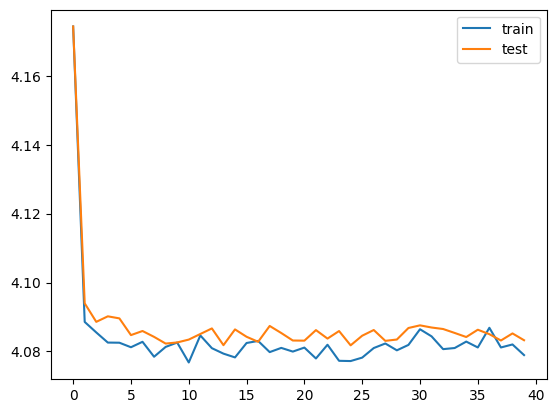

In [33]:
dataset = CharacterDataset.from_textfile('./input.txt', block_size=256)
train_dataset,test_dataset = dataset.train_test_split()
model = MarkovPredictor(dataset.vocab_size)

batch_size = 10
train_steps = 200
train_losses = []
test_losses = []
train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, replacement=True, num_samples=train_steps * batch_size),
    batch_size=batch_size,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset, replacement=True, num_samples=20),
    batch_size=batch_size,
)

for i,(x,y) in enumerate(tqdm(train_dataloader)):
    # Calculate losses every 5 steps
    if i % 5 == 0:
        _,loss = model(x,y)
        train_losses.append(loss.item())
        test_loss = torch.tensor([model(test_x,test_y)[1] for test_x, test_y in test_dataloader])
        test_losses.append(torch.mean(test_loss).item())
    # Count letter order in training data
    for batch in zip(x,y):
        for x_i,y_i in zip(*batch):
            model.next_token[x_i][y_i] += 1

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

# Evaluate
The model has learned some structure, e.g. there are probably a bit more newlines and a colon is always followed by a newline. 

In [34]:
for sample in model.generate():
    print(sample)

  0%|          | 0/256 [00:00<?, ?it/s]


Tq$3ZzW&x3?PARD:
TENG$&$$&ZETLThy y?
$ZA$KISTORD:
S!UK:
WzBOP&ZABu$&z$zqTXThexZMENGXx$PDWARWxJusq$xZQULO,
DYOPOF PukJXZjelovtr.
WAUELONORD&KBULOx&bu.&$ZJUKERAPHOLOXE:
KIZXF'GJ&BYxq$$quld.
WAPP&QQXERDUSS:--$Q&J$ZANIVOLENG?
TERDIZQUS:
JBRKELLOR:
F&z,---by FB
